# Partial wakes verification

In the following we investigate the accuracy of various partial wakes models. 

We do this by comparison with the approximation of the truth that is provided by the choice `rotor_model=grid400` in combination with `partial_wakes=rotor_points`. 

Our playground is the following turbine and wind setup:

- Uniform wind from wind direction 270 degrees
- One turbine located at `x = y = 0`, causing a wake
- Another turbine located at `x = 4D` and 1000 different `y` positions between `y = -500 m` and `y = 500 m`, acting as a "probe" of the wind field.

This setup will lead to different partial wakes situations, and the partial wakes models will try to predict the correct effective wake effect at the probe turbine.

Let's see how well they perform at this task!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

Let's initialize the engine:

In [2]:
engine = foxes.Engine.new("process", chunk_size_states=1000)
engine.initialize()

Next, we create a pandas DataFrame object that contains data for 1000 ambient states, including the different `y` positions of the probe turbine:

In [3]:
Ny = 1000
ws0 = 9.0

sdata = pd.DataFrame(index=range(Ny + 1))
sdata.index.name = "state"
sdata["ws"] = ws0
sdata["wd"] = 270
sdata["ti"] = 0.05
sdata["rho"] = 1.225
sdata["y"] = np.linspace(-500, 500, Ny + 1)

sdata

,ws,wd,ti,rho,y
state,,,,,
0,9.0,270,0.05,1.225,-500.0
1,9.0,270,0.05,1.225,-499.0
2,9.0,270,0.05,1.225,-498.0
3,9.0,270,0.05,1.225,-497.0
4,9.0,270,0.05,1.225,-496.0
...,...,...,...,...,...
996,9.0,270,0.05,1.225,496.0
997,9.0,270,0.05,1.225,497.0
998,9.0,270,0.05,1.225,498.0


The main _foxes_ calculation is carried out by the following function. Notice how the turbine model `SetFarmVars` is used for initializing the different `y` positions:

In [4]:
def calc(rotor, pwake, wake):
    states = foxes.input.states.StatesTable(
        sdata,
        output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
        var2col={FV.WS: "ws", FV.WD: "wd", FV.TI: "ti", FV.RHO: "rho"},
    )

    ydata = np.full((len(sdata.index), 2), np.nan)
    ydata[:, 1] = sdata["y"].to_numpy()

    ttype = "DTU10MW"
    mbook = foxes.ModelBook()
    mbook.turbine_models["sety"] = foxes.models.turbine_models.SetFarmVars(
        pre_rotor=True
    )
    mbook.turbine_models["sety"].add_var(FV.Y, ydata)
    D = mbook.turbine_types[ttype].D

    farm = foxes.WindFarm()
    farm.add_turbine(
        foxes.Turbine(xy=np.array([0.0, 0.0]), turbine_models=[ttype]),
        verbosity=0,
    )
    farm.add_turbine(
        foxes.Turbine(
            xy=np.array([4 * D, 0.0]),
            turbine_models=["sety", ttype],
        ),
        verbosity=0,
    )

    algo = foxes.algorithms.Downwind(
        farm,
        states,
        wake_models=[wake],
        rotor_model=rotor,
        partial_wakes=pwake,
        mbook=mbook,
        verbosity=0,
    )

    print(f"Calculating rotor = {rotor}, pwake = {pwake}")
    farm_results = algo.calc_farm()

    return farm_results, D

This function calls the above function for a given list of partial wakes models, called `pwakes`:

In [5]:
def run_calc(rotor, pwakes, wake):
    results = {}
    for pwake in pwakes:
        farm_results, D = calc(rotor, pwake, wake)
        results[pwake] = farm_results
    return results, D

Another function will be used for evaluating the calculation results dictionary, creating a plot of results:

In [6]:
def get_plot(results, D, rotor, figsize=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize)

    for pwake, fres in results.items():
        ls = "--" if pwake == "rotor_points" else "-"
        lw = 3 if pwake == "rotor_points" else 2
        ax.plot(
            fres[FV.Y][:, 1] / D,
            fres[FV.REWS][:, 1] / ws0,
            linestyle=ls,
            linewidth=lw,
            alpha=0.8,
            label=pwake,
        )

    title = f"4D behind the rotor, ws0 = {ws0} m/s, rotor = {rotor}"
    ax.set_title(title)
    ax.set_xlabel("y/D")
    ax.legend()

    return ax

Now we can start the evaluation. First, let's look at partial wakes of the `grid` type, for a Gaussian wake model:

Calculating rotor = grid400, pwake = rotor_points


ProcessEngine: Calculating 1001 states for 2 turbines


ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████                                              | 1/2 [00:00<00:00,  8.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.18it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = centre


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.42it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = grid4


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.09it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = grid9


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.17it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = grid16


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.18it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = grid100


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.16it/s]

ProcessEngine: Completed all 2 chunks



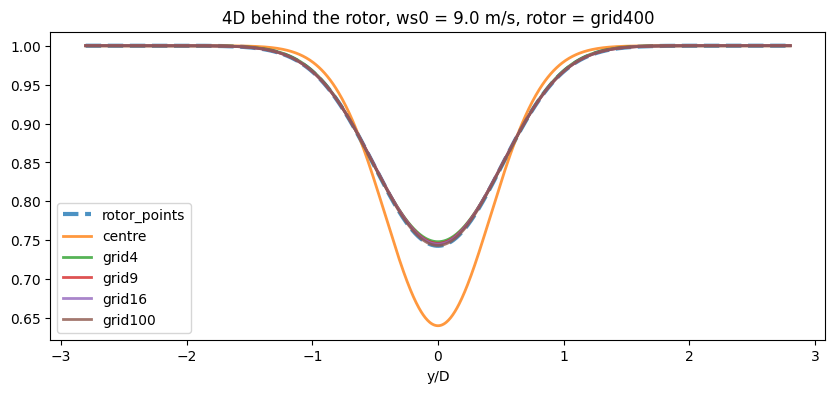

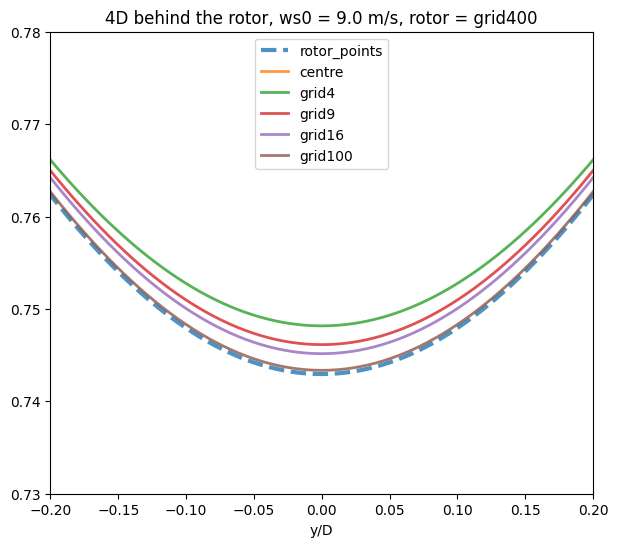

In [7]:
rotor = "grid400"
wake = "Bastankhah2014_linear_k004"
pwakes = ["rotor_points", "centre", "grid4", "grid9", "grid16", "grid100"]
results, D = run_calc(rotor, pwakes, wake)

ax = get_plot(results, D, rotor)
plt.show()

ax = get_plot(results, D, rotor, figsize=(7, 6))
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(0.73, 0.78)
ax.legend(loc="upper center")
plt.show()

Next, we repeat the exercise with `axiwake` partial wakes, which approach the "true" result with much less wake evaluation points:

Calculating rotor = grid400, pwake = rotor_points


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████                                              | 1/2 [00:00<00:00,  9.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.64it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = centre


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.63it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = axiwake4


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.94it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = axiwake6


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.05it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = axiwake9


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.74it/s]

ProcessEngine: Completed all 2 chunks



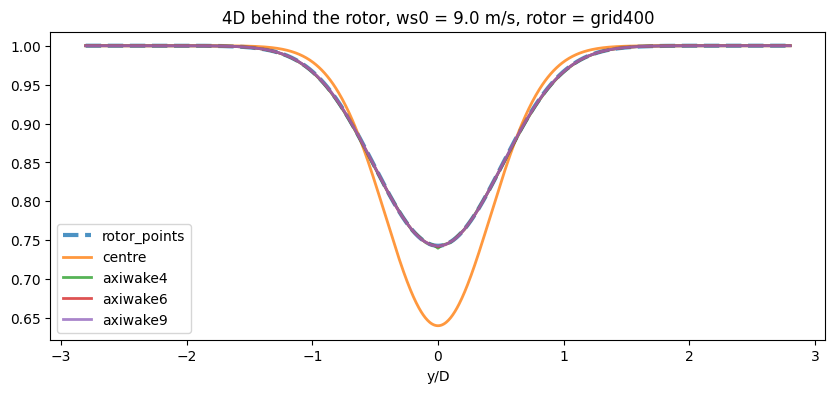

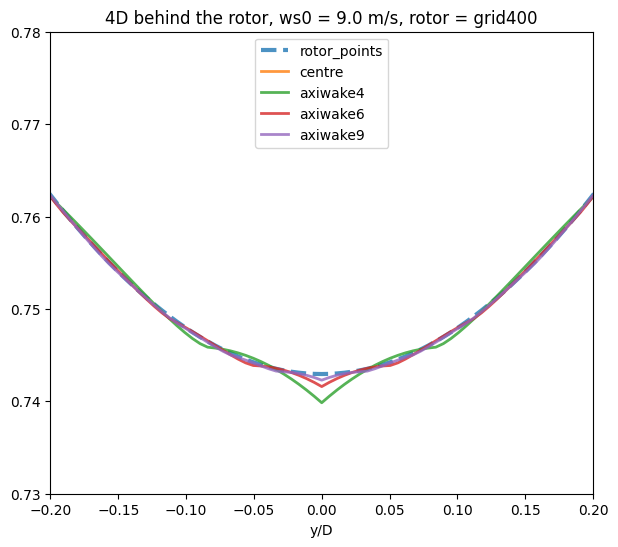

In [8]:
rotor = "grid400"
wake = "Bastankhah2014_linear_k004"
pwakes = ["rotor_points", "centre", "axiwake4", "axiwake6", "axiwake9"]
results, D = run_calc(rotor, pwakes, wake)

ax = get_plot(results, D, rotor)
plt.show()

ax = get_plot(results, D, rotor, figsize=(7, 6))
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(0.73, 0.78)
ax.legend(loc="upper center")
plt.show()

For top-hat models, the `top_hat` partial wakes are exact and fast:

Calculating rotor = grid400, pwake = rotor_points


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.07it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = centre


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.90it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = grid16


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.80it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = axiwake9


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.36it/s]

ProcessEngine: Completed all 2 chunks

Calculating rotor = grid400, pwake = top_hat


ProcessEngine: Calculating 1001 states for 2 turbines
ProcessEngine: Computing 2 chunks using 15 workers


  0%|                                                                                                    | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.21it/s]

ProcessEngine: Completed all 2 chunks



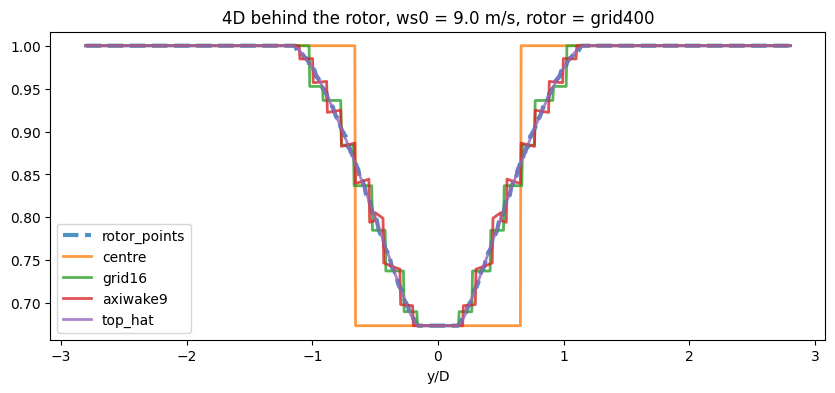

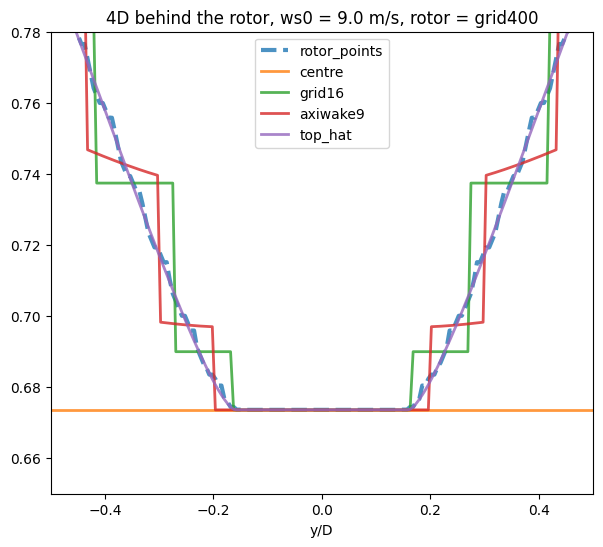

In [9]:
rotor = "grid400"
wake = "Jensen_linear_k004"
pwakes = ["rotor_points", "centre", "grid16", "axiwake9", "top_hat"]
results, D = run_calc(rotor, pwakes, wake)

ax = get_plot(results, D, rotor)
plt.show()

ax = get_plot(results, D, rotor, figsize=(7, 6))
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0.65, 0.78)
ax.legend(loc="upper center")
plt.show()

Clearly the `top_hat` choice is the only one that can handle wake models with  `top_hat` shape.

After all work is done, we shutdown the engine:

In [10]:
engine.finalize()